<a href="https://colab.research.google.com/github/iurrutia/CO2_LSTM/blob/master/LSTM_MaunaLoa_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting models for time series data

First part is adapted from Scott's notebook: https://github.com/slpitz/RNNandGHGs/blob/master/RNN_MaunaLoa_data.ipynb

Second part is keras LSTM for time series prediction, comparing to fitting regression.

Third part is pytorch LSTM for time series prediction. 

# 1. Import monthly average CO2 concentration from Mauna Loa

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   

In [4]:


myfile = 'ftp://aftp.cmdl.noaa.gov/data/trace_gases/co2/flask/surface/co2_mlo_surface-flask_1_ccgg_month.txt'
myfile2019 = 'ftp://aftp.cmdl.noaa.gov/data/trace_gases/co2/in-situ/surface/mlo/co2_mlo_surface-insitu_1_ccgg_MonthlyData.txt'
      
# making data frame   
#df = pd.read_csv(myfile,sep='\t',skiprows=(0,1,2),header=(70))
#df = pd.read_csv(myfile,sep='\r',header=(69), delim_whitespace=True)
#df = pd.read_csv(myfile2019, header= (150), delim_whitespace=True)
df = pd.read_csv(myfile2019, header= (149), delim_whitespace=True)
    
df.head()  

,site_code,year,month,day,hour,minute,second,time_decimal,value,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
0,MLO,1973,1,1,0,0,0,1973.000000,-999.99,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..
1,MLO,1973,2,1,0,0,0,1973.084932,-999.99,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..
2,MLO,1973,3,1,0,0,0,1973.161644,-999.99,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..
3,MLO,1973,4,1,0,0,0,1973.246575,-999.99,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..
4,MLO,1973,5,1,0,0,0,1973.328767,-999.99,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..


In [5]:
df.tail()

,site_code,year,month,day,hour,minute,second,time_decimal,value,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
559,MLO,2019,8,1,0,0,0,2019.580822,409.99,0.51,29,19.536,-155.576,3437.0,3397.0,40.0,...
560,MLO,2019,9,1,0,0,0,2019.665753,408.54,0.39,29,19.536,-155.576,3437.0,3397.0,40.0,...
561,MLO,2019,10,1,0,0,0,2019.747945,408.51,0.47,29,19.536,-155.576,3437.0,3397.0,40.0,...
562,MLO,2019,11,1,0,0,0,2019.832877,410.29,0.43,26,19.536,-155.576,3437.0,3397.0,40.0,...
563,MLO,2019,12,1,0,0,0,2019.915068,411.76,0.72,31,19.536,-155.576,3437.0,3397.0,40.0,...


In [6]:
df.columns

Index(['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'time_decimal', 'value', 'value_std_dev', 'nvalue', 'latitude',
       'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag'],
      dtype='object')

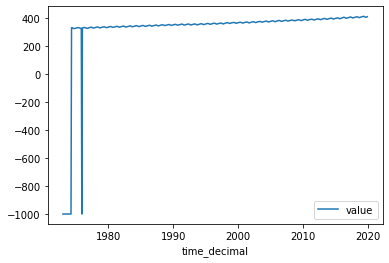

In [7]:
df.plot(x="time_decimal", y='value')

In [34]:
df1974 = df[df.value > 0] #remove values of -999
df1974.head()


,site_code,year,month,day,hour,minute,second,time_decimal,value,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
16,MLO,1974,5,1,0,0,0,1974.328767,333.16,0.34,14,19.536,-155.576,3437.0,3397.0,40.0,...
17,MLO,1974,6,1,0,0,0,1974.413699,332.11,0.46,26,19.536,-155.576,3437.0,3397.0,40.0,...
18,MLO,1974,7,1,0,0,0,1974.495890,331.11,0.49,24,19.536,-155.576,3437.0,3397.0,40.0,...
19,MLO,1974,8,1,0,0,0,1974.580822,329.09,0.64,27,19.536,-155.576,3437.0,3397.0,40.0,...
20,MLO,1974,9,1,0,0,0,1974.665753,327.27,0.63,24,19.536,-155.576,3437.0,3397.0,40.0,...


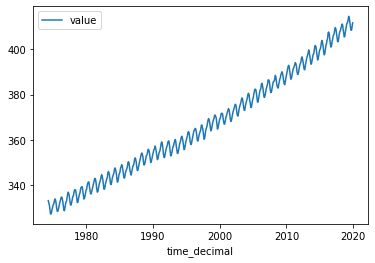

In [9]:
df1974.plot(x="time_decimal", y='value')

In [10]:
#df1974 is missing data from December of 1975
df1976 = df[df.year > 1975] #remove values of before 1976
df1976.head(20)

,site_code,year,month,day,hour,minute,second,time_decimal,value,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
36,MLO,1976,1,1,0,0,0,1976.000000,331.65,0.29,20,19.536,-155.576,3437.0,3397.0,40.0,...
37,MLO,1976,2,1,0,0,0,1976.084699,332.76,0.55,22,19.536,-155.576,3437.0,3397.0,40.0,...
38,MLO,1976,3,1,0,0,0,1976.163934,333.54,0.84,20,19.536,-155.576,3437.0,3397.0,40.0,...
39,MLO,1976,4,1,0,0,0,1976.248634,334.66,0.72,19,19.536,-155.576,3437.0,3397.0,40.0,...
40,MLO,1976,5,1,0,0,0,1976.330601,334.77,0.61,22,19.536,-155.576,3437.0,3397.0,40.0,...
41,MLO,1976,6,1,0,0,0,1976.415301,334.21,0.22,17,19.536,-155.576,3437.0,3397.0,40.0,...
42,MLO,1976,7,1,0,0,0,1976.497268,332.85,0.68,16,19.536,-155.576,3437.0,3397.0,40.0,...
43,MLO,1976,8,1,0,0,0,1976.581967,330.72,0.75,23,19.536,-155.576,3437.0,3397.0,40.0,...
44,MLO,1976,9,1,0,0,0,1976.666667,328.88,0.99,13,19.536,-155.576,3437.0,3397.0,40.0,...
45,MLO,1976,10,1,0,0,0,1976.748634,328.71,0.56,20,19.536,-155.576,3437.0,3397.0,40.0,...


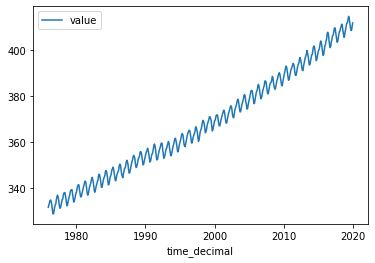

In [11]:
df1976.plot(x="time_decimal", y='value')

In [12]:
seriesLength = len(df1976)-12 #length minus the last year
len(df1976)

528

# 2. LSTM - keras

Following this example: 

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [13]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [14]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [15]:
df1976.columns

Index(['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'time_decimal', 'value', 'value_std_dev', 'nvalue', 'latitude',
       'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag'],
      dtype='object')

In [16]:
# Select the necessary columns
dataset = df1976[["time_decimal", "value"]]
dataset.head()

,time_decimal,value
36,1976.000000,331.65
37,1976.084699,332.76
38,1976.163934,333.54
39,1976.248634,334.66
40,1976.330601,334.77


In [17]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.        , 0.0342139 ],
       [0.00192871, 0.04713139],
       [0.00373299, 0.05620854],
       ...,
       [0.9961944 , 0.92866287],
       [0.99812839, 0.9493774 ],
       [1.        , 0.96648435]])

In [18]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

353 175


In [19]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [20]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [21]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [22]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0543
Epoch 2/100
 - 0s - loss: 0.0162
Epoch 3/100
 - 0s - loss: 0.0083
Epoch 4/100
 - 0s - loss: 0.0027
Epoch 5/100
 - 0s - loss: 4.5297e-04
Epoch 6/100
 - 0s - loss: 6.8523e-05
Epoch 7/100
 - 0s - loss: 4.2833e-05
Epoch 8/100
 - 0s - loss: 3.9517e-05
Epoch 9/100
 - 0s - loss: 3.5981e-05
Epoch 10/100
 - 0s - loss: 3.2999e-05
Epoch 11/100
 - 0s - loss: 2.9528e-05
Epoch 12/100
 - 0s - loss: 2.5922e-05
Epoch 13/100
 - 0s - loss: 2.2789e-05
Epoch 14/100
 - 0s - loss: 1.8695e-05
Epoch 15/100
 - 0s - loss: 1.6029e-05
Epoch 16/100
 - 0s - loss: 1.3064e-05
Epoch 17/100
 - 0s - loss: 1.2324e-05
Epoch 18/100
 - 0s - loss: 1.0284e-05
Epoch 19/100
 - 0s - loss: 9.8463e-06
Epoch 20/100
 - 0s - loss: 9.3342e-06
Epoch 21/100
 - 0s - loss: 9.3148e-06
Epoch 22/100
 - 0s - loss: 9.4794e-06
Epoch 23/100
 - 0s - loss: 1.0335e-05
Epoch 24/100
 - 0s - loss: 9.6138e-06
Epoch 25/100
 - 0s - loss: 1.0804e-05
Epoch 26/100
 - 0s - loss: 9.9740e-06
Epoch 27/100
 - 0s - loss: 1.0516e-05

In [23]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

ValueError: ignored

# 2. LSTM - pytorch

Following this example: 

https://github.com/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

In [24]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [25]:
# Same data as from above:
df.head(5)

,site_code,year,month,day,hour,minute,second,time_decimal,value,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
0,MLO,1973,1,1,0,0,0,1973.000000,-999.99,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..
1,MLO,1973,2,1,0,0,0,1973.084932,-999.99,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..
2,MLO,1973,3,1,0,0,0,1973.161644,-999.99,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..
3,MLO,1973,4,1,0,0,0,1973.246575,-999.99,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..
4,MLO,1973,5,1,0,0,0,1973.328767,-999.99,-99.99,0,19.536,-155.576,3437.0,3397.0,40.0,*..


<function matplotlib.pyplot.show>

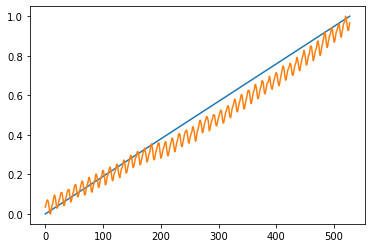

In [32]:
# Visualization of training data (kind of linear, but not really)
plt.plot(dataset, label = "year")
plt.show

<function matplotlib.pyplot.show>

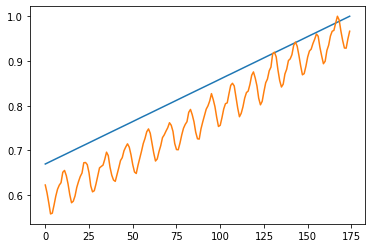

In [31]:
# Visualization of test data (kind of linear, but not really)
plt.plot(test, label = "year")
plt.show